In [0]:
import math
import random 
from collections import defaultdict
from pprint import pprint

#prevent future depreciation and warnning
import warnings 
warnings.filterwarnings(action='ignore')

#Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#setting
sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

In [0]:
from google.colab import files
files.upload()

# IMPORTING DATA

In [14]:
df = pd.read_csv("reddit_headlines_labels")
df1 = pd.read_csv("reddit_headlines_labels_2")
df = df.append(df1)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 2 columns):
headline    1912 non-null object
label       1912 non-null int64
dtypes: int64(1), object(1)
memory usage: 30.0+ KB


In [39]:
df = df[df.label!=0]
df['label'].value_counts()

-1    686
 1    360
Name: label, dtype: int64

In [50]:
#Transform headline into features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

s1 = "Senate panel moving ahead with Mueller bill despite McConnell opposition"
s2 = "Bill protecting Robert Mueller to get vote despite McConnell opposition"

vect = CountVectorizer(binary=True)
X = vect.fit_transform([s1, s2])

X.toarray()

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]])

In [51]:
list(zip(X.toarray()[0], vect.get_feature_names()))

[(1, 'ahead'),
 (1, 'bill'),
 (1, 'despite'),
 (0, 'get'),
 (1, 'mcconnell'),
 (1, 'moving'),
 (1, 'mueller'),
 (1, 'opposition'),
 (1, 'panel'),
 (0, 'protecting'),
 (0, 'robert'),
 (1, 'senate'),
 (0, 'to'),
 (0, 'vote'),
 (1, 'with')]

In [88]:
vect = CountVectorizer(max_features=1000, binary=True)
X = vect.fit_transform(df.headline)

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Preprocessing Data

In [0]:
from sklearn.model_selection import train_test_split

X = df.headline
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)

In [54]:
counts = df.label.value_counts()
print(counts)

print("\nPredicting only -1 = {:.2f}% accuracy".format(counts[-1] / sum(counts) * 100))

-1    686
 1    360
Name: label, dtype: int64

Predicting only -1 = 65.58% accuracy


In [0]:
#making equal samples of -1 and +1 by oversampliting with the help of SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [56]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(-1, 551), (1, 551)]


# NAIVE BAYES

In [45]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.862453531598513

In [0]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

In [47]:
#f1 score calculated from harmonic mean with the help of confusion matrix
# it gives more analytic power than just accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 78.10%

F1 Score: 65.15

COnfusion Matrix:
 [[121  27]
 [ 19  43]]


# Cross Validation

In [19]:
#K-fold cross validation
#Monte carlo validation
from sklearn.model_selection import ShuffleSplit

X = df.headline
y = df.label

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
  # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
  
  # Fit Naive Bayes on the vectorized X with y train labels, 
  # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
  # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

NameError: ignored

# Plotting

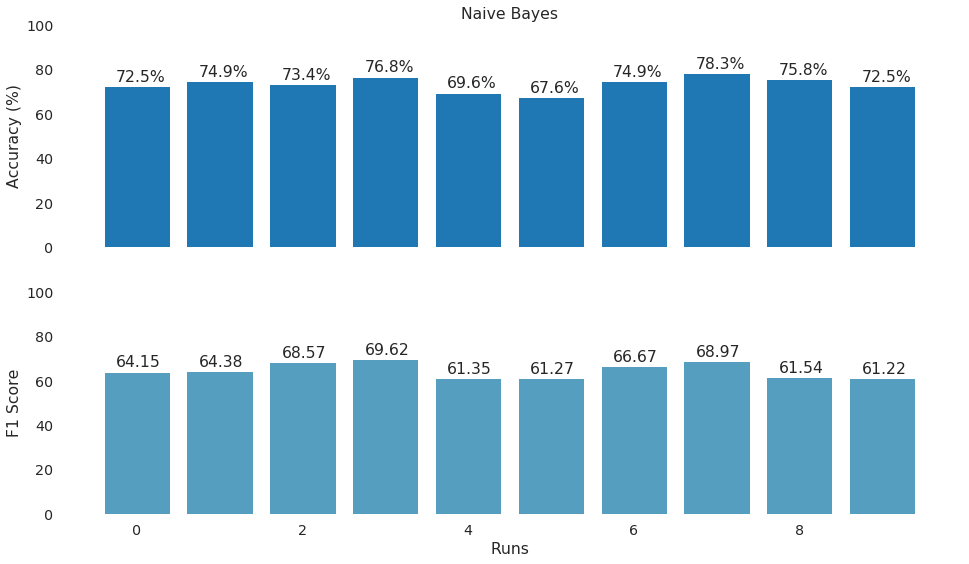

In [100]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

# Other Classification Algorithm in Scikit-learn

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

vect = CountVectorizer(max_features=1000, binary=True)

X = df.headline
y = df.label

cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

sm=SMOTE()

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X): 
    X_train ,X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   
    #vectorization
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
  
    #problem of oversampling
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
  
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

In [74]:
for model,d in results.items():
  avg_acc = sum(d['accuracy'])/len(d['accuracy'])*100
  avg_f1 = sum(d['f1_score'])/len(d['f1_score'])*100
  avg_cm = sum(d['confusion_matrix'])/len(d['confusion_matrix'])
  
  slashes = '-'*30
  
  s = f"""{model}\n{slashes}
      average_accuaracy : {avg_acc:.2f}%
      average_f1_score : {avg_f1:.2f}
      average_consusion_matrix : 
      \n{avg_cm}
      """
  print(s)

MultinomialNB
------------------------------
      average_accuaracy : 73.43%
      average_f1_score : 63.23
      average_consusion_matrix : 
      
[[106.05  34.  ]
 [ 21.8   48.15]]
      
BernoulliNB
------------------------------
      average_accuaracy : 68.21%
      average_f1_score : 61.25
      average_consusion_matrix : 
      
[[90.3  49.75]
 [17.   52.95]]
      
LogisticRegression
------------------------------
      average_accuaracy : 71.52%
      average_f1_score : 61.34
      average_consusion_matrix : 
      
[[102.5   37.55]
 [ 22.25  47.7 ]]
      
SGDClassifier
------------------------------
      average_accuaracy : 69.86%
      average_f1_score : 58.51
      average_consusion_matrix : 
      
[[101.75  38.3 ]
 [ 25.    44.95]]
      
LinearSVC
------------------------------
      average_accuaracy : 70.60%
      average_f1_score : 59.98
      average_consusion_matrix : 
      
[[101.75  38.3 ]
 [ 23.45  46.5 ]]
      
RandomForestClassifier
----------------------

# Esembling Classifiers

In [0]:
from sklearn.ensemble import VotingClassifier

X = df.headline
y = df.label

cv = ShuffleSplit(n_splits=10, test_size = 0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

#3 precious lines
m_names = [m.__class__.__name__ for m in models]

models = list(zip(m_names, models))
vc = VotingClassifier(estimators=models)

sm=SMOTE()

# No need for dictionary now
accs = []
f1s = []
cms = []

for train_index, test_index in cv.split(X):
  X_train,X_test = X.iloc[train_index],X.iloc[test_index]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]
  
  #vectorize
  X_train_vect = vect.fit_transform(X_train)
  X_test_vect = vect.transform(X_test)
  
  #oversampling problem
  X_train_vect_res,y_train_vect_res = sm.fit_sample(X_train_vect,y_train)
  
  vc.fit(X_train_vect_res,y_train_vect_res)
  
  y_pred = vc.predict(X_test_vect)
  
  accs.append(accuracy_score(y_test,y_pred))
  f1s.append(f1_score(y_test, y_pred))
  cms.append(confusion_matrix(y_test, y_pred))


In [78]:
print("Voting Classifier")
print("-" * 30)
print("Avg. Accuracy: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Avg. F1 Score: {:.2f}".format(sum(f1s) / len(f1s) * 100))
print("Confusion Matrix:\n", sum(cms) / len(cms))

Voting Classifier
------------------------------
Avg. Accuracy: 71.81%
Avg. F1 Score: 60.57
Confusion Matrix:
 [[105.   36.2]
 [ 23.   45.8]]
